# Load data
Sibsp：在船上同為兄弟姐妹或配偶的數目<br>
Parch：在船上同為家族的父母及小孩的數目

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

data = pd.read_csv('titanic.csv')
X = data.iloc[:,1:]
Y = pd.get_dummies(data['Survived'], prefix='Survived')

# print ('value counts of Pclass:')
print (pd.value_counts(data['Pclass']))
X.head()

3    491
1    216
2    184
Name: Pclass, dtype: int64


,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,1,22.0,1,0,7.2500
1,1,0,38.0,1,0,71.2833
2,3,0,26.0,0,0,7.9250
3,1,0,35.0,1,0,53.1000
4,3,1,35.0,0,0,8.0500


# Correlation

In [45]:
data.corr('spearman')

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
Survived,1.000000,-0.339668,-0.543351,0.029758,0.088879,0.138266,0.323736
Pclass,-0.339668,1.000000,0.135775,-0.363244,-0.043019,-0.022801,-0.688032
Sex,-0.543351,0.135775,1.000000,0.015835,-0.195204,-0.254512,-0.259593
Age,0.029758,-0.363244,0.015835,1.000000,-0.055498,-0.071694,0.212917
SibSp,0.088879,-0.043019,-0.195204,-0.055498,1.000000,0.450014,0.447113
Parch,0.138266,-0.022801,-0.254512,-0.071694,0.450014,1.000000,0.410074
Fare,0.323736,-0.688032,-0.259593,0.212917,0.447113,0.410074,1.000000


# Train & Test

In [46]:
X_train, X_test = np.array(X.iloc[:800,:]), np.array(X.iloc[-91:,:])
Y_train, Y_test = np.array(Y.iloc[:800,:]), np.array(Y.iloc[-91:,:])
print (X_train.shape, Y_train.shape)

(800, 6) (800, 2)


# 標準化

In [47]:
# 對Fare做標準化
mu = np.mean(X_train[:,-1])
std = np.std(X_train[:,-1])
X_train[:,-1] = (X_train[:,-1]-mu) / std
X_test[:,-1] = (X_test[:,-1]-mu) / std

# # 對Age做標準化
# mu = np.mean(X_train[:,2])
# std = np.std(X_train[:,2])
# X_train[:,2] = (X_train[:,2]-mu) / std
# X_test[:,2] = (X_test[:,2]-mu) / std

# # 對SibSp做標準化
# mu = np.mean(X_train[:,3])
# std = np.std(X_train[:,3])
# X_train[:,3] = (X_train[:,3]-mu) / std
# X_test[:,3] = (X_test[:,3]-mu) / std

# # 對Parch做標準化
# mu = np.mean(X_train[:,4])
# std = np.std(X_train[:,4])
# X_train[:,4] = (X_train[:,4]-mu) / std
# X_test[:,4] = (X_test[:,4]-mu) / std

# Build model

In [48]:
def relu(x):
    return np.maximum(0,x)
def drelu(x):
    return 1. * (x > 0)
    
def tanh(x):
    return np.tanh(x)
def dtanh(x):
    return 1.-tanh(x)*tanh(x)

def softmax(x):
    x = np.exp(x)
    x_sum = np.sum(x,axis=1).reshape(-1,1) # 記得要逐row計算sum，且要reshape否則下一行沒法除
    x = x / x_sum
    return x

def cross_entropy(label, pred, epsilon=1e-10):
    pred = np.clip(pred, epsilon, 1. - epsilon) # 限制在epsilon~1-epsilon之間
    N = pred.shape[0]
    ce = -np.sum(np.sum(label * np.log(pred + 1e-8))) / N
    return ce

def draw(loss_train, loss_test, acc_test, acc_train):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
    f.tight_layout()
    
    ax1.plot(loss_test, label='Test')
    ax1.plot(loss_train, label='Train')
    ax1.legend()
    ax1.set_xlabel('Epochs')
    ax1.set_title('Loss')
    
    ax2.plot(1-np.array(acc_test), label='Test')
    ax2.plot(1-np.array(acc_train), label='Train')
    ax2.legend()
    ax2.set_xlabel('Epochs')
    ax2.set_title('Error rate')
    plt.show()
    
#     plt.plot(acc_test, label='Test')
#     plt.plot(acc_train, label='Train')
#     plt.legend()
#     plt.title('Accuracy')
#     plt.xlabel('Epochs')
#     plt.show()

In [49]:
class NN():
    def __init__(self, UNITS, ACT, LR, INIT):
        np.random.seed(123) # 設seed來固定每次亂數的結果
        # 嘗試不同的初始化方法，在講義41頁
        if INIT==0:
            self.w1 = np.ones((UNITS[0], UNITS[1]))
            self.w2 = np.ones((UNITS[1], UNITS[2]))
            self.w3 = np.ones((UNITS[2], UNITS[3]))
        elif INIT==1:  
            self.w1 = np.random.randn(UNITS[0], UNITS[1]) 
            self.w2 = np.random.randn(UNITS[1], UNITS[2]) 
            self.w3 = np.random.randn(UNITS[2], UNITS[3]) 
        elif INIT==2:
            self.w1 = np.random.randn(UNITS[0], UNITS[1]) / np.sqrt(UNITS[0])
            self.w2 = np.random.randn(UNITS[1], UNITS[2]) / np.sqrt(UNITS[1])
            self.w3 = np.random.randn(UNITS[2], UNITS[3]) / np.sqrt(UNITS[2])
        elif INIT==3:
            self.w1 = np.random.randn(UNITS[0], UNITS[1]) * np.sqrt(6/(UNITS[0]+UNITS[1]))
            self.w2 = np.random.randn(UNITS[1], UNITS[2]) * np.sqrt(6/(UNITS[1]+UNITS[2]))
            self.w3 = np.random.randn(UNITS[2], UNITS[3]) * np.sqrt(6/(UNITS[2]+UNITS[3]))
        
        self.lr = LR
        if ACT == relu:
            self.act = relu
            self.dact = drelu
        if ACT == tanh:
            self.act = tanh
            self.dact = dtanh
        
    def forward(self, INPUT):
        self.z1 = np.dot(INPUT, self.w1)
        self.h1 = self.act(self.z1)
        
        self.z2 = np.dot(self.h1, self.w2)
        self.h2 = self.act(self.z2)
        
        self.z3 = np.dot(self.h2, self.w3)
        OUTPUT = softmax(self.z3)
        
        return OUTPUT
    
    def backpropagation(self, INPUT, LABEL, OUTPUT):
        self.loss_d = LABEL - OUTPUT  
        self.gradient_w3 = np.dot(self.h2.T, self.loss_d)
        
        self.gradient_h2 = self.loss_d.dot(self.w3.T)
        self.h2_delta = self.gradient_h2 * self.dact(self.z2)
        self.gradient_w2 = np.dot(self.h1.T, self.h2_delta)
        
        self.gradient_h1 = self.h2_delta.dot(self.w2.T)
        self.h1_delta = self.gradient_h1 * self.dact(self.z1)
        self.gradient_w1 = np.dot(INPUT.T, self.h1_delta)

        self.w3 += self.lr * self.gradient_w3
        self.w2 += self.lr * self.gradient_w2
        self.w1 += self.lr * self.gradient_w1
        
    def train(self, X, Y):
        OUTPUT = self.forward(X)
        self.backpropagation(X, Y, OUTPUT)

    def evaluate(self, X, Y):
        PRED = self.forward(X)
        loss = cross_entropy(PRED, Y)
        acc = np.equal(np.argmax(PRED, axis=1), np.argmax(Y, axis=1)).mean()
        return loss, acc

# Training

In [50]:
def run(X_train, X_test, MODEL, EPOCH, BATCH_SIZE, ACT, LR, INIT):

    model = MODEL([X_train.shape[1],3,3,Y_train.shape[1]], ACT, LR, INIT)
    for i in range(1, EPOCH+1):
#         if i % 100 ==0:
#             print ('Epoch:',i)
        index = np.random.permutation(X_train.shape[0])  # 產生隨機的index
        batch_count = 0
        while batch_count* BATCH_SIZE < X_train.shape[0]:
            batch_X , batch_Y = X_train[batch_count*BATCH_SIZE:(batch_count+1)*BATCH_SIZE], Y_train[batch_count*BATCH_SIZE:(batch_count+1)*BATCH_SIZE]
    #         print(batch_X.shape, batch_Y.shape)
            batch_count += 1

            model.train(batch_X, batch_Y)
        loss_tr, acc_tr = model.evaluate(X_train, Y_train)
        loss_te, acc_te = model.evaluate(X_test, Y_test)
        loss_train.append(loss_tr)
        loss_test.append(loss_te)
        acc_train.append(acc_tr)
        acc_test.append(acc_te)
        
    print ('Accuracy:')
    print ('train:',model.evaluate(X_train, Y_train)[1])
    print ('test:',model.evaluate(X_test, Y_test)[1])

Accuracy:
train: 0.81875
test: 0.8461538461538461


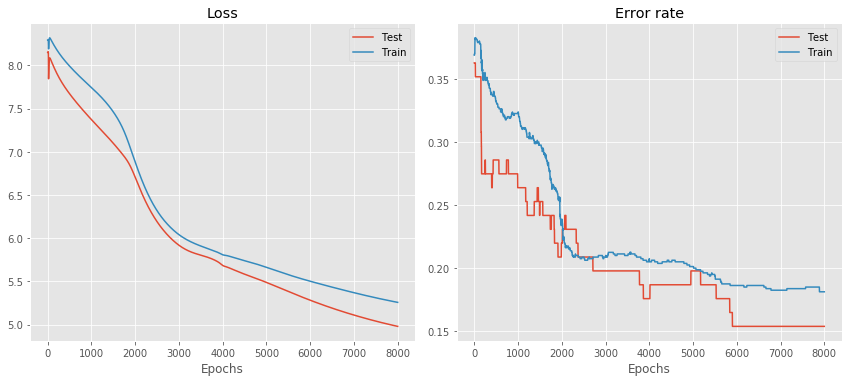

In [51]:
EPOCH = 8000
BATCH_SIZE = 100
ACT = tanh
LR = 0.00001
INIT = 2
model = NN([X_train.shape[1],4,2,Y_train.shape[1]], ACT, LR, INIT)
loss_train, loss_test, acc_train, acc_test =[], [], [], []

for i in range(1, EPOCH+1):
#         if i % 100 ==0:
#             print ('Epoch:',i)
    index = np.random.permutation(X_train.shape[0])  # 產生隨機的index
    batch_count = 0
    while batch_count* BATCH_SIZE < X_train.shape[0]:
        batch_X , batch_Y = X_train[batch_count*BATCH_SIZE:(batch_count+1)*BATCH_SIZE], Y_train[batch_count*BATCH_SIZE:(batch_count+1)*BATCH_SIZE]
#         print(batch_X.shape, batch_Y.shape)
        batch_count += 1

        model.train(batch_X, batch_Y)
    loss_tr, acc_tr = model.evaluate(X_train, Y_train)
    loss_te, acc_te = model.evaluate(X_test, Y_test)
    loss_train.append(loss_tr)
    loss_test.append(loss_te)
    acc_train.append(acc_tr)
    acc_test.append(acc_te)

print ('Accuracy:')
print ('train:',model.evaluate(X_train, Y_train)[1])
print ('test:',model.evaluate(X_test, Y_test)[1])
draw(loss_train, loss_test, acc_test, acc_train)

# Activation function 比較

<function relu at 0x0000025F73765510>
Accuracy:
train: 0.64375
test: 0.6263736263736264


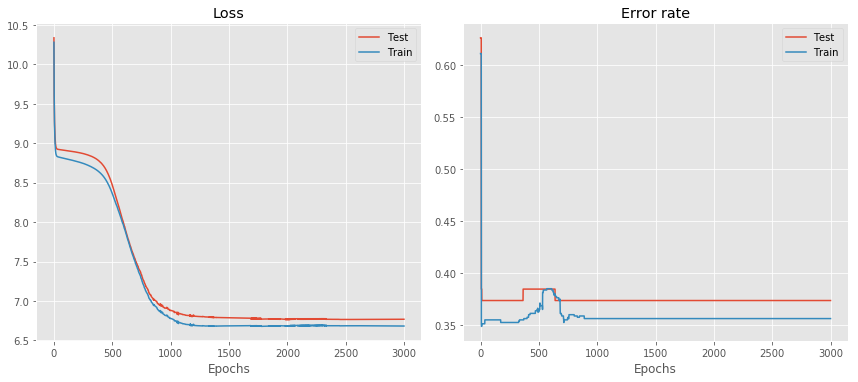

<function tanh at 0x0000025F73720B70>
Accuracy:
train: 0.795
test: 0.8131868131868132


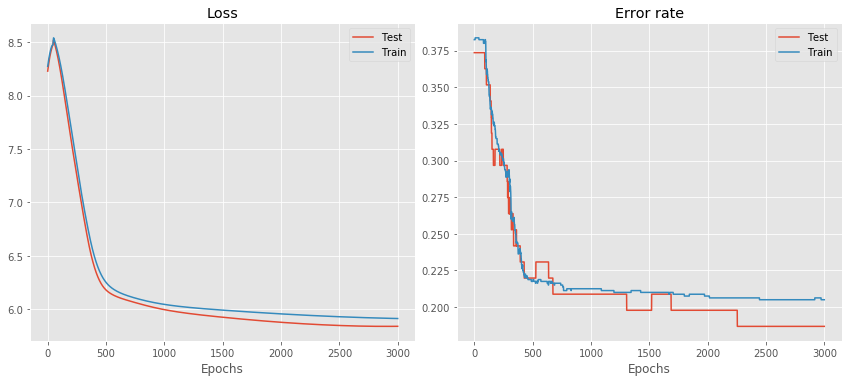

In [52]:
EPOCH = 3000
BATCH_SIZE = 100
ACT = relu
LR = 0.00005
INIT = 2
for ACT in [relu, tanh]:
    print (ACT)
    loss_train, loss_test, acc_train, acc_test =[], [], [], []
    run(X_train, X_test, NN, EPOCH, BATCH_SIZE, ACT, LR, INIT)
    draw(loss_train, loss_test, acc_test, acc_train)

# Weight initialization比較

Weight initialization: 0
Accuracy:
train: 0.615
test: 0.6263736263736264


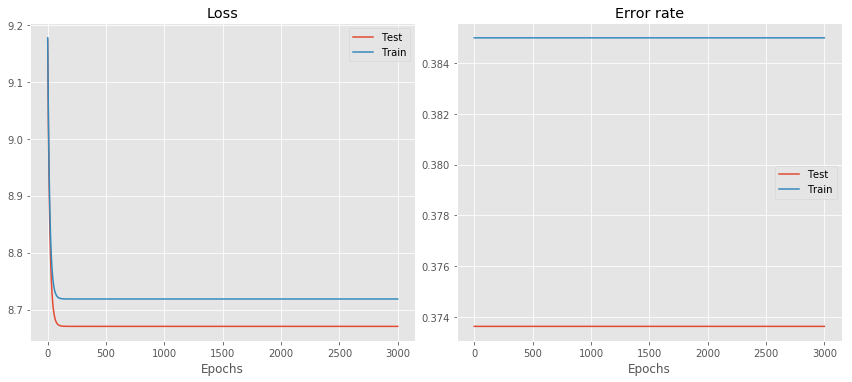

Weight initialization: 1
Accuracy:
train: 0.64625
test: 0.6373626373626373


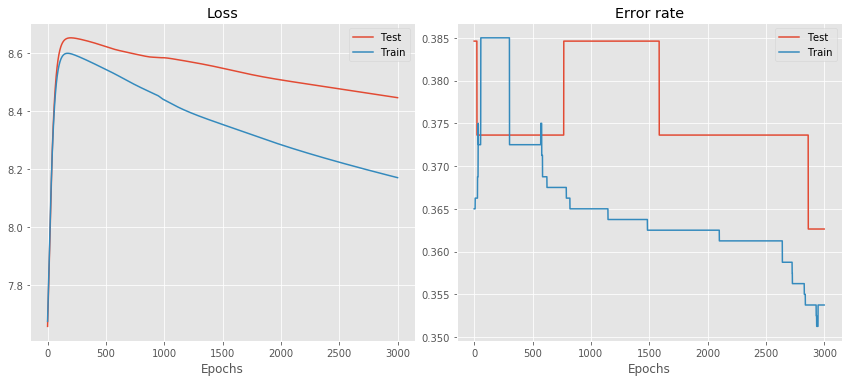

Weight initialization: 2
Accuracy:
train: 0.795
test: 0.8131868131868132


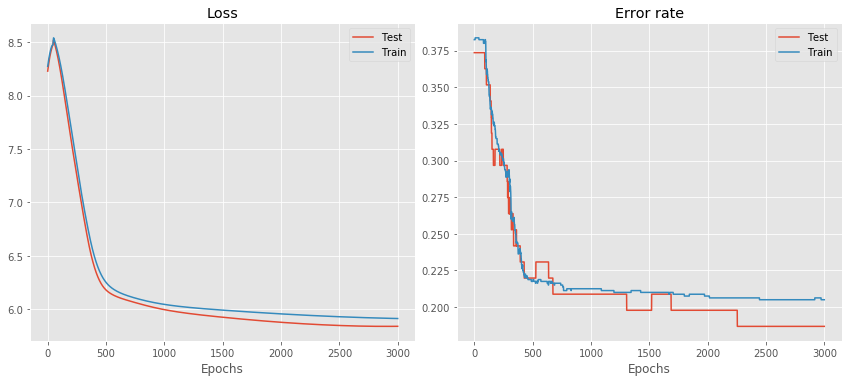

Weight initialization: 3
Accuracy:
train: 0.655
test: 0.6263736263736264


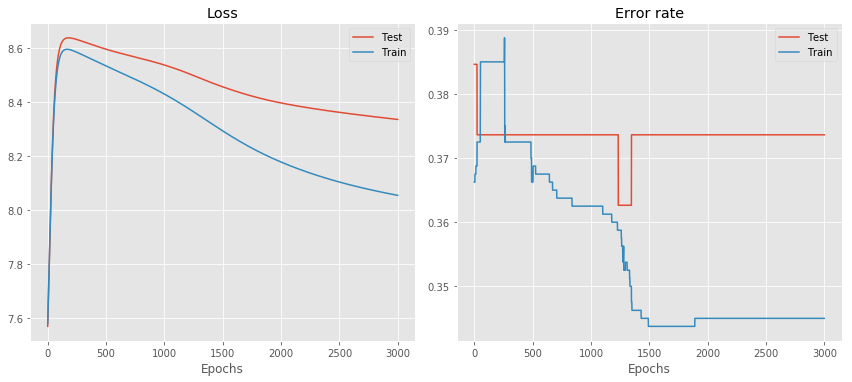

In [53]:
ACT = tanh

for INIT in [0,1,2,3]:
    print ('Weight initialization:',INIT)
    loss_train, loss_test, acc_train, acc_test =[], [], [], []
    run(X_train, X_test, NN, EPOCH, BATCH_SIZE, ACT, LR, INIT)
    draw(loss_train, loss_test, acc_test, acc_train)

# Batch size比較

Weight initialization: 2
Accuracy:
train: 0.79125
test: 0.8021978021978022


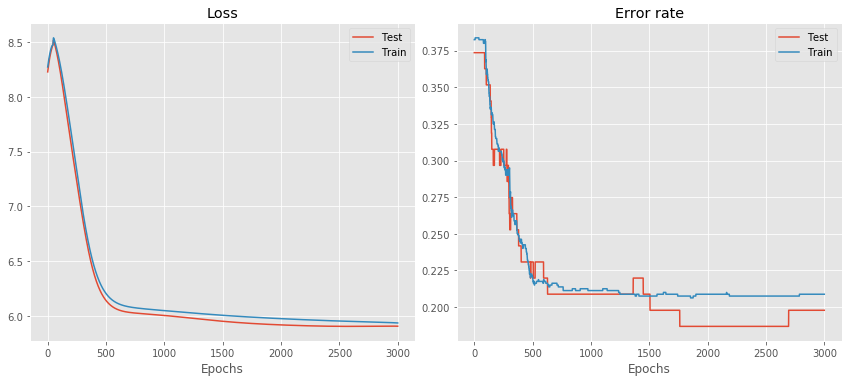

Weight initialization: 2
Accuracy:
train: 0.795
test: 0.8131868131868132


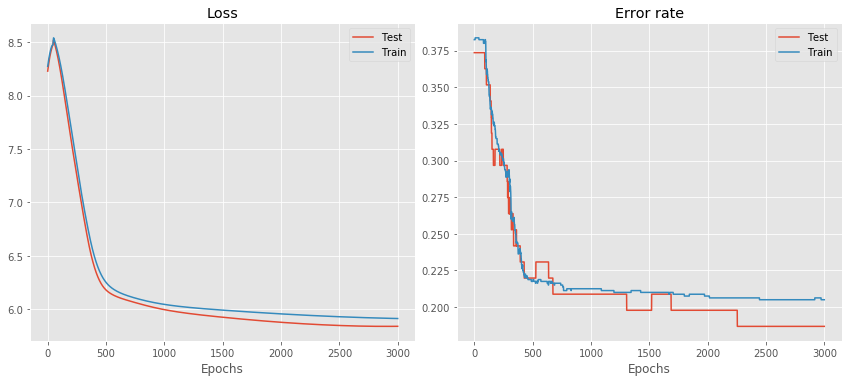

Weight initialization: 2
Accuracy:
train: 0.80875
test: 0.8021978021978022


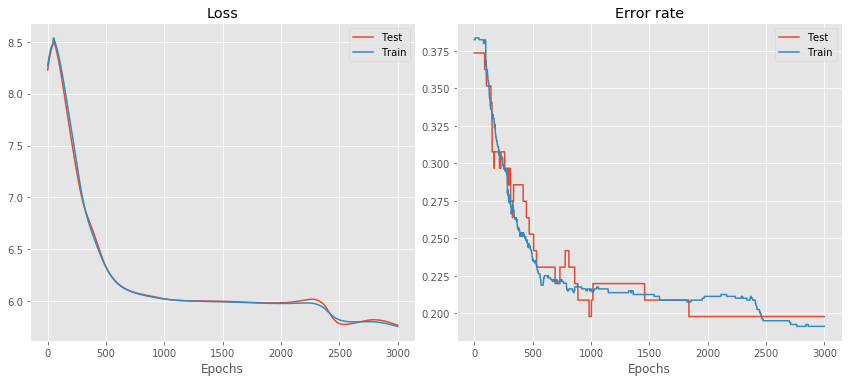

Weight initialization: 2
Accuracy:
train: 0.79
test: 0.8131868131868132


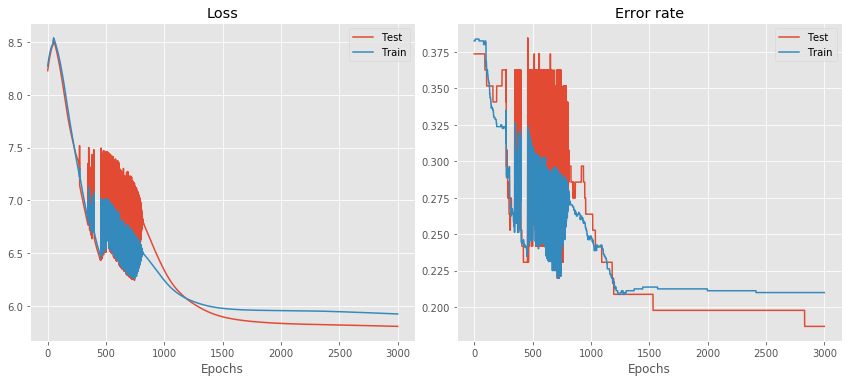

In [54]:
ACT = tanh
INIT = 2
for BATCH_SIZE in [50,100,150,200]:
    print ('Weight initialization:',INIT)
    loss_train, loss_test, acc_train, acc_test =[], [], [], []
    run(X_train, X_test, NN, EPOCH, BATCH_SIZE, ACT, LR, INIT)
    draw(loss_train, loss_test, acc_test, acc_train)

# 比較單一特徵

Feature: Pclass
Accuracy:
train: 0.67125
test: 0.7472527472527473


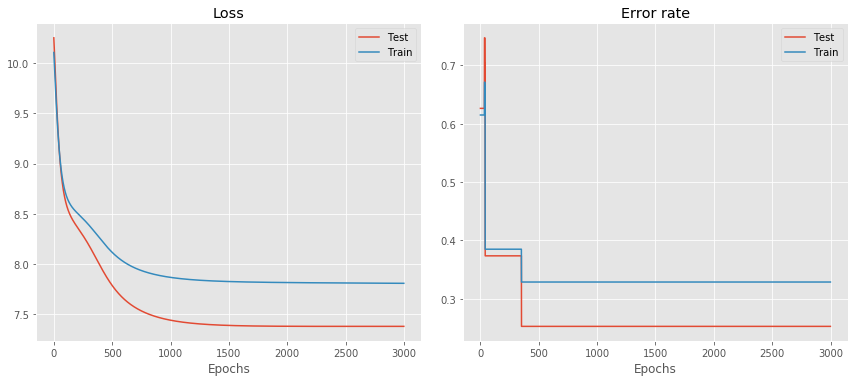

Feature: Sex
Accuracy:
train: 0.615
test: 0.6263736263736264


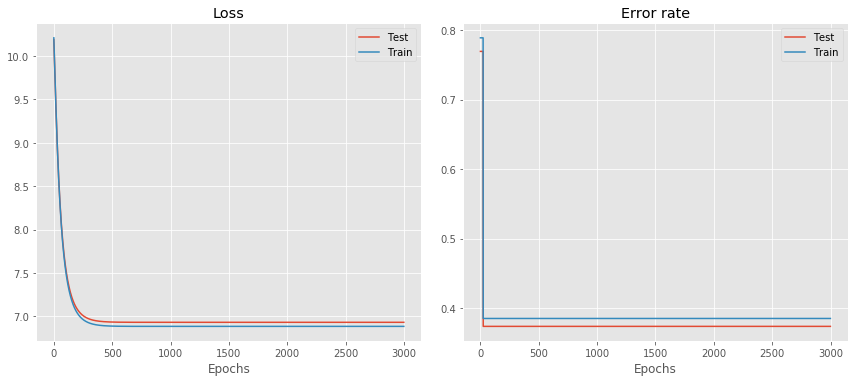

Feature: Age
Accuracy:
train: 0.635
test: 0.6483516483516484


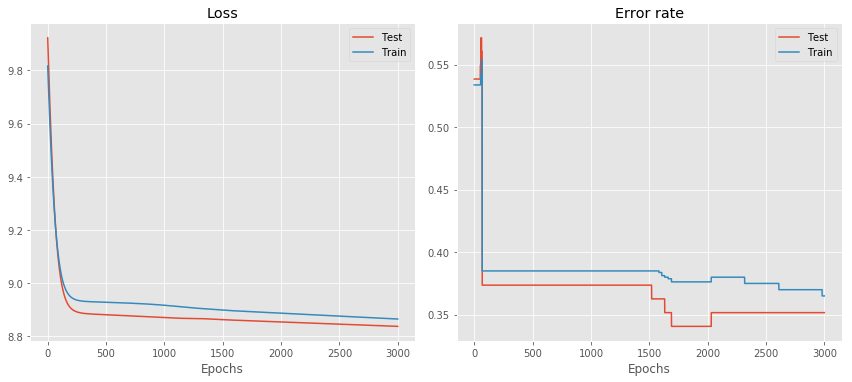

Feature: SibSp
Accuracy:
train: 0.62375
test: 0.7142857142857143


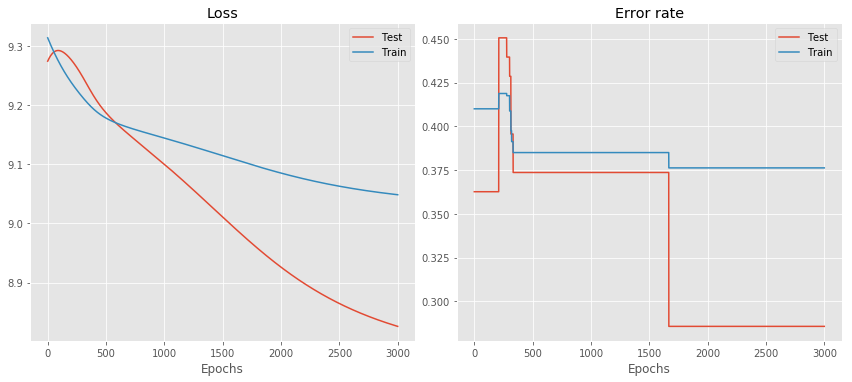

Feature: Parch
Accuracy:
train: 0.61875
test: 0.7252747252747253


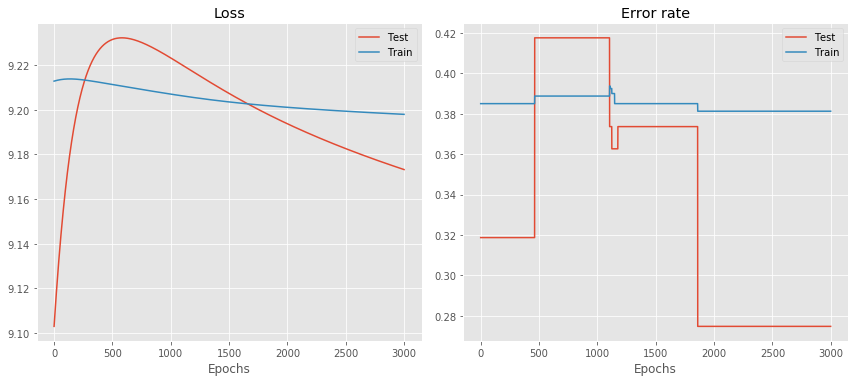

Feature: Fare
Accuracy:
train: 0.6575
test: 0.6923076923076923


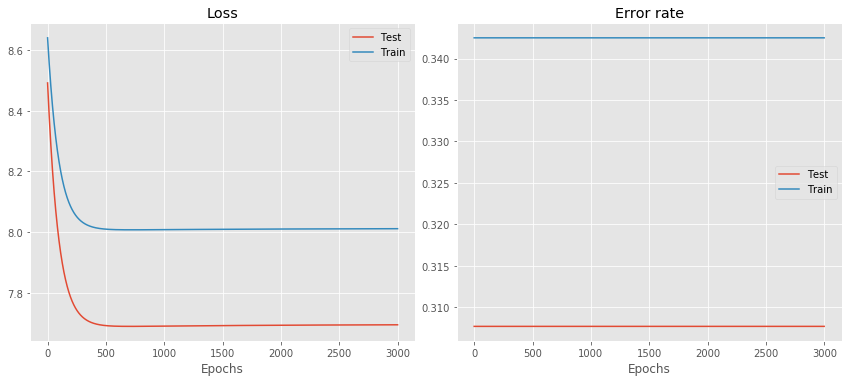

In [55]:
ACT = tanh
INIT = 2
BATCH_SIZE = 100
for f in range(X_train.shape[1]):
    print ('Feature:', X.columns[f])
    loss_train, loss_test, acc_train, acc_test =[], [], [], []
    run(X_train[:,f].reshape(-1,1), X_test[:,f].reshape(-1,1), NN, EPOCH, BATCH_SIZE, ACT, LR, INIT)
    draw(loss_train, loss_test, acc_test, acc_train)

# P class one-hot

Accuracy:
train: 0.79375
test: 0.8131868131868132


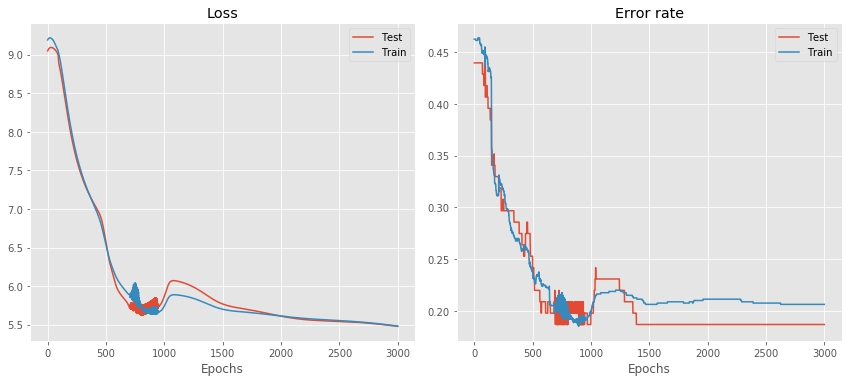

In [56]:
p1, p2 = pd.get_dummies(X_train[:,0]), pd.get_dummies(X_test[:,0])
X_train_onehot = np.concatenate([p1, X_train[:,1:]], axis=1)
X_test_onehot = np.concatenate([p2, X_test[:,1:]], axis=1)

loss_train, loss_test, acc_train, acc_test =[], [], [], []
run(X_train_onehot, X_test_onehot, NN, EPOCH, BATCH_SIZE, ACT, LR, INIT)
draw(loss_train, loss_test, acc_test, acc_train)

# 自製存活者

In [57]:
# Model
EPOCH = 3000
BATCH_SIZE = 100
LR = 0.00005

model = NN([X_train.shape[1],3,3,Y_train.shape[1]], tanh, LR, INIT)
for i in range(1, EPOCH+1):
#         if i % 100 ==0:
#             print ('Epoch:',i)
    index = np.random.permutation(X_train.shape[0])  # 產生隨機的index
    batch_count = 0
    while batch_count* BATCH_SIZE < X_train.shape[0]:
        batch_X , batch_Y = X_train[batch_count*BATCH_SIZE:(batch_count+1)*BATCH_SIZE], Y_train[batch_count*BATCH_SIZE:(batch_count+1)*BATCH_SIZE]
#         print(batch_X.shape, batch_Y.shape)
        batch_count += 1

        model.train(batch_X, batch_Y)

In [115]:
# 1:男性
p1 = np.array([1, 0, 20, 0, 0, 2]).reshape(1,-1)
model.forward(p1)

array([[0.10066861, 0.89933139]])

In [116]:
p2 = np.array([3, 1, 25, 1, 2, -2]).reshape(1,-1)
model.forward(p2)

array([[0.82572227, 0.17427773]])